This notebook shows how we explore various aspects of ML model develop steps.


In [1]:
import os
import numpy as np
import datetime as dt
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr


In [2]:
def get_dataframe(df, file_base, data_type='_obs'):
    file_name = file_base + data_type + '.nc4'
    ds = xr.open_dataset(file_name)
    df_tmp = ds.to_dataframe()
    ds.close()
    df = pd.concat((df, df_tmp))
    return df 


In [3]:
target = 'ges'
ml_data_dir = '/scratch1/NCEPDEV/stmp2/Xin.C.Jin/ml_test/orig/'
months = ['01', '02']
days = ['02', '12']
init = True
df_obs = pd.DataFrame()
df_geo = pd.DataFrame()
df_ch = pd.DataFrame()
for month in months:
    for day in days:
        diag_day = f'gdas.2023{month}{day}'
        input_file_base = os.path.join(ml_data_dir, diag_day,f'diag_amsua_n19_{target}.2023{month}{day}')
        obs_file_name = input_file_base + '_obs.nc4'
        df_obs = get_dataframe(df_obs, input_file_base, data_type='_obs')
        df_geo = get_dataframe(df_geo, input_file_base, data_type='_geo')
        df_ch = get_dataframe(df_ch, input_file_base, data_type='_ch')
    

In [4]:
df_ch.columns = df_ch.columns.str.lower()
df_obs.columns = df_obs.columns.str.lower()
df_geo.columns = df_geo.columns.str.lower()
print(f'{df_ch.shape}, {df_geo.shape}, {df_obs.shape}')
print(f'{df_ch.columns}, \n\n {df_geo.columns}, \n\n {df_obs.columns}')
nobs = len(df_obs)
iters = len(df_geo)
nchans = 15
assert iters * nchans == nobs, f'{iters} * {nchans} should be: {nobs}'

(60, 9), (147270, 48), (2209050, 14)
Index(['chaninfoidx', 'frequency', 'polarization', 'wavenumber',
       'error_variance', 'mean_lapse_rate', 'use_flag', 'sensor_chan',
       'satinfo_chan'],
      dtype='object'), 

 Index(['latitude', 'longitude', 'elevation', 'obs_time', 'scan_position',
       'sat_zenith_angle', 'sat_azimuth_angle', 'sol_zenith_angle',
       'sol_azimuth_angle', 'sun_glint_angle', 'scan_angle', 'water_fraction',
       'land_fraction', 'ice_fraction', 'snow_fraction', 'water_temperature',
       'land_temperature', 'ice_temperature', 'snow_temperature',
       'soil_temperature', 'soil_moisture', 'land_type_index', 'tsavg5',
       'sstcu', 'sstph', 'sstnv', 'dta', 'dqa', 'dtp_avh',
       'vegetation_fraction', 'snow_depth', 'tpwc', 'clw_guess_retrieval',
       'sfc_wind_speed', 'cloud_frac', 'ctp', 'clw', 'tpwc', 'clw_obs',
       'clw_guess', 'foundation_temperature', 'sst_warm_layer_dt',
       'sst_cool_layer_tdrop', 'sst_dtz_dtfound', 'bc_scan_angle',

All predictors:
- 'BC_Constant', 
- 'BC_Scan_Angle','Scan_Angle'
- 'BC_Cloud_Liquid_Water', 'CLW'
- 'BC_Lapse_Rate_Squared',  'mean_lapse_rate',
- 'BC_Lapse_Rate', 'mean_lapse_rate',
- 'BC_Cosine_Latitude_times_Node', 'Latitude',
- 'BC_Sine_Latitude', 'Latitude',
- 'BC_Emissivity', 'Emissivity'
- 'BC_Fixed_Scan_Position', 'Scan_Position',
- 'BC_angord'
```
#pred_names = ['Observation', 'Scan_Angle', 'CLW', 'Weighted_Lapse_Rate', 'Latitude',  'Emissivity', 'Scan_Position', 'mean_lapse_rate']
# pred_names = ['Scan_Angle', 'mean_lapse_rate', 'Latitude',  'Emissivity', 'Scan_Position']

df['tlap'] = df['Weighted_Lapse_Rate'] - df['mean_lapse_rate'] # 5
df['tlap_square'] = df['tlap']**2 # 4
df['cos_lat'] = np.cos(df['Latitude'] * deg_to_rad) * df['Sat_Azimuth_Angle'] * deg_to_rad  # 6
df['sin_lat'] = np.sin(df['Latitude'] * deg_to_rad) # 7
cosza = np.cos(df['Sat_Zenith_Angle'] * deg_to_rad)
df['scan_angle'] = np.square(1/cosza - 1)
df['clw_obs'] = df['CLW'] * cosza * cosza  # 3
df['emissivity'] = df['Emissivity'] # 8
scan_angle = df['Scan_Angle'] * deg_to_rad
df['scan_1'] =  scan_angle  # 9
df['scan_2'] =  scan_angle**2 #10
df['scan_3'] =  scan_angle**3  #11
df['scan_4'] =  scan_angle**4  #12
df['obs'] = df['Observation']
df['bc_total'] = df['Obs_Minus_Forecast_unadjusted'] - df['Obs_Minus_Forecast_adjusted']
pred_names = ['tlap', 'tlap_square', 'cos_lat', 'sin_lat', 'scan_angle', 
             'clw_obs', 'emissivity', 'scan_1', 'scan_2', 'scan_3',
             'scan_4', 'obs']
y_name = ['Obs_Minus_Forecast_unadjusted', 'bc_total']

pred_names = ['cos_lat', 'sin_lat', 'scan_angle', 'clw_obs', 'emissivity', 'scan_1', 'scan_2', 'scan_3','scan_4', 
            'obs', 'tlap', 'tlap_square']
```

In [5]:
#pred_names = ['Observation', 'Scan_Angle', 'CLW', 'Weighted_Lapse_Rate', 'Latitude',  'Emissivity', 'Scan_Position', 'mean_lapse_rate']
# pred_names = ['Scan_Angle', 'mean_lapse_rate', 'Latitude',  'Emissivity', 'Scan_Position']
deg_to_rad = np.pi /180

wlr = df_obs['weighted_lapse_rate'].to_numpy().reshape(iters, nchans)
mlr = df_ch['mean_lapse_rate'].to_numpy()[0:nchans]
tlap = wlr - mlr
tlap_square = tlap**2
df_geo['cos_lat'] = np.cos((df_geo['latitude']) * deg_to_rad) * df_geo['sat_azimuth_angle'] * deg_to_rad
df_geo['sin_lat'] = np.sin((df_geo['latitude']) * deg_to_rad)
cosza = np.cos(df_geo['sat_azimuth_angle'] * deg_to_rad)
scan_angle = np.square(1/cosza - 1)
df_geo['clw_obs'] = df_geo['clw'] * cosza * cosza  # 3
emissivity = df_obs['emissivity'].to_numpy().reshape(iters, nchans)
scan_angle0 = df_geo['scan_angle'].to_numpy() * deg_to_rad
df_geo['scan_1'] =  scan_angle0  # 9
df_geo['scan_2'] =  scan_angle0**2 #10
df_geo['scan_3'] =  scan_angle0**3  #11
df_geo['scan_4'] =  scan_angle0**4  #12
obs = df_obs['observation'].to_numpy().reshape(iters, nchans)
bc_total = (df_obs['obs_minus_forecast_unadjusted'] - df_obs['obs_minus_forecast_adjusted']).to_numpy().reshape(iters, nchans)
omf_unadjusted = df_obs['obs_minus_forecast_unadjusted'].to_numpy().reshape(iters, nchans)


In [6]:
max_omf = 30
sea = (df_geo['land_fraction']==0.0) & (df_geo['ice_fraction']==0.0) & (df_geo['snow_fraction']==0.0)
qc_flag_0 = df_obs['qc_flag'].to_numpy().reshape(iters, nchans)
qc_flag = (qc_flag_0[:,0] == 0)
qc_omf = (omf_unadjusted[:, 0] < max_omf)
for i in range(1,15):
    qc_flag &=  (qc_flag_0[:,i] == 0)
    qc_omf &= (omf_unadjusted[:, i] < max_omf)
# mask = sea & qc_flag & (df_geo['clw_obs'] < 100)
mask = qc_flag
# mask = qc_omf & (df_geo['clw_obs'] < 100) 

In [7]:
pred_name = ['cos_lat', 'sin_lat', 'scan_1', 'scan_2', 'scan_3','scan_4', 'clw_obs', 'scan_angle']
data_df = df_geo[pred_name][mask]

bc_total = bc_total[mask]


In [8]:
X_0 = data_df.to_numpy()
X = np.concatenate((X_0, obs[mask], tlap[mask], emissivity[mask]), axis=1) 
Y = omf_unadjusted[mask]

In [9]:
total_number = X.shape[0]
n_train = int(total_number/5. * 4)
n_test =  int(total_number/5.)
print(n_train, n_test)
X_train = X[0 : n_train, :]
X_test =  X[n_train:, :]
Y_train = Y[0 : n_train, :]
bc_tot = bc_total[n_train:, :]
#pred_names = ['Observation', 'Scan_Angle', 'Weighted_Lapse_Rate', 'Latitude', 'Emissivity']
Y_test =  Y[n_train:, :]
print(X_train.shape, X_test.shape, Y_train.shape)


32978 8244
(32978, 53) (8245, 53) (32978, 15)


In [10]:
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)



In [11]:
mlp_regressor = MLPRegressor(random_state=1, hidden_layer_sizes=(50, 50))

In [12]:
regr = mlp_regressor.fit(X_train_scaled, Y_train)

/scratch1/NCEPDEV/da/Xin.C.Jin/miniconda3/envs/mmlwc/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [13]:
# Make predictions using the testing set
y_pred = regr.predict(X_test_scaled)
regr.score(X_test_scaled, Y_test)

0.2023974299008082

In [14]:
y_pred.shape
i = 0

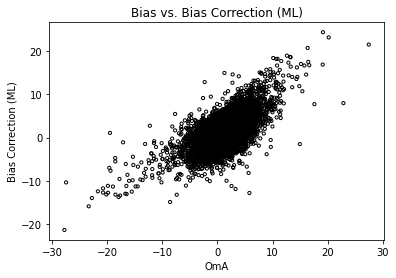

In [15]:
# Plot outputs
plt.scatter(Y_test[:, i], y_pred[:, i], color="black", facecolors='none', s=10, marker='o')
#plt.plot(x_test['Latitude'], y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())
# plt.ylim(-40, 40)
plt.xlabel('OmA')
plt.ylabel('Bias Correction (ML)')
plt.title('Bias vs. Bias Correction (ML)')
plt.show()

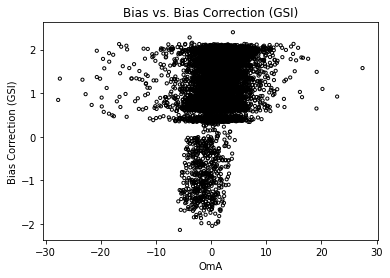

In [16]:
# Plot outputs
plt.scatter(Y_test[:, i], bc_tot[:, i], color="black", facecolors='none', s=10, marker='o')
#plt.plot(x_test['Latitude'], y_pred, color="blue", linewidth=3)

# plt.xticks(())
# plt.yticks(())
# plt.ylim(-40, 40)
plt.xlabel('OmA')
plt.ylabel('Bias Correction (GSI)')
plt.title('Bias vs. Bias Correction (GSI)')
plt.show()

In [17]:
df_y = {}
df_y['bc_0'] = Y_test
df_y['bc_1'] = Y_test - bc_tot
df_y['bc_2'] = Y_test - y_pred


In [18]:
def plot_pdf(df_y, x_min, x_max, ch=0, save_name=None):
   # fig = plt.figure(figsize=(8, 12))
    x_axis = np.arange(-x_min, x_max, 0.01) 
    # Calculating mean and standard deviation 
    # mean = np.mean(df_y[:, ch])
    mean = 0 
    sd = np.std(df_y[:, ch])
    plt.hist(df_y[:, ch], bins=50, alpha=0.5, density=True, range=(-x_min, x_max))
    plt.grid(True)
    plt.plot(x_axis, norm.pdf(x_axis, mean, sd), label="Un-normalized",color="blue")
    plt.title(f'Hist for channel: {ch + 1}')
    if save_name:
        file_name = f'figures/hist_{ch}_{save_name}.png'
        plt.savefig(file_name)
    #plt.close(fig)

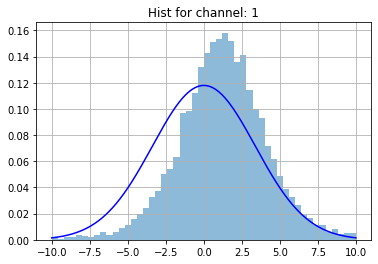

In [19]:
i=0
from scipy.stats import norm 
plot_pdf(df_y['bc_0'], 10, 10)
plt.show()

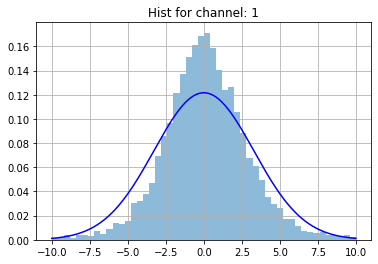

In [20]:
plot_pdf(df_y['bc_1'], 10, 10)

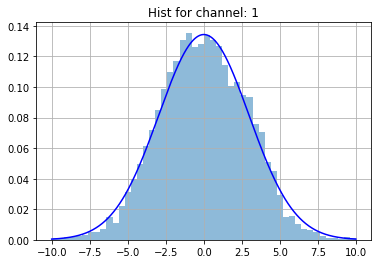

In [21]:
plot_pdf(df_y['bc_2'], 10, 10)

In [22]:
print(f" mean: {np.mean(df_y['bc_0'])}, std: {np.std(df_y['bc_0'])}")
print(f" mean: {np.mean(df_y['bc_1'])}, std: {np.std(df_y['bc_1'])}")
print(f" mean: {np.mean(df_y['bc_2'])}, std: {np.std(df_y['bc_2'])}")

 mean: 0.2924923598766327, std: 2.3107187747955322
 mean: -0.01575087383389473, std: 2.1726021766662598
 mean: -0.008801707085803544, std: 1.784597112804957


In [23]:
def plot_stats(func, stats_type, save_name=None):
    bc_type = ('bc_0', 'bc_1', 'bc_2')
    mark_type = ('s', 'v', 'o')
    bc_lg = ('OmF', 'BC(GSI)', 'BC(ML)')
    line_width = 4
    x = range(15)
    for bc, sb in zip(bc_type, mark_type):
        bc_stats = func(df_y[bc], axis=0)
        plt.scatter(x, bc_stats, marker=sb, linewidths=line_width)
    # ax = df_bc.plot(kind='scatter', grid=True, xlabel='Channel Number', ylabel='Std')
    plt.legend(bc_lg, loc='upper center')
    plt.grid(True)
    plt.xlabel('Channel Number')
    plt.ylabel(stats_type)
    if save_name:
        file_name =f'figures/stats_{stats_type}'
        plt.savefig(file_name)

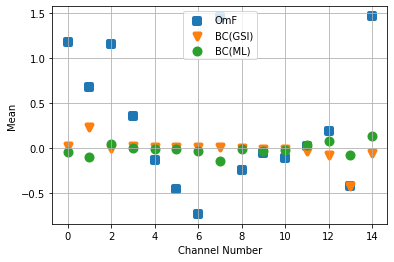

In [24]:
plot_stats(np.mean, 'Mean')

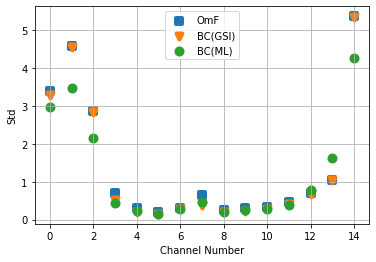

In [25]:
plot_stats(np.std, 'Std')